<h1 align=center><font size = 5>Scrape Data of Neighborhoods in New York City</font></h1>

## Table of Contents
1. <a href="#item1"> Downlowd and Explore Dataset</a>
2. <a href="#item2"> Extract Venue Data for Neighborhoods in NewYork </a>
3. <a href ="item3">Analyze Venues with Super Category</a>

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

<a id='item1'></a>

## 1. Download and Explore Dataset

In [6]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [9]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [11]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [12]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [15]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Create a map of New York with neighborhoods superimposed on top.

In [ ]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'EMDHRUDTJF4AQ2T1PTM5GUFKORZA0DM5VY4RBARSILADEC1S' # your Foursquare ID
CLIENT_SECRET = 'Z3JVMNXKOV3YLTCBKAJHKXLAHYXNACVQYQ2YUURY5MXBH4UK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EMDHRUDTJF4AQ2T1PTM5GUFKORZA0DM5VY4RBARSILADEC1S
CLIENT_SECRET:Z3JVMNXKOV3YLTCBKAJHKXLAHYXNACVQYQ2YUURY5MXBH4UK


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's latitude and longitude values.

In [19]:
neighborhood_latitude = neighborhoods.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[1, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Co-op City are 40.87429419303012, -73.82993910812398.


In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<a id="item2"></a>

<a id='item2'></a>

## 2. Extract Venue Data for Neighborhoods in NewYork

#### Let's create a function to repeat the same process to all the neighborhoods

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000,LIMIT=100):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        
        if  'groups' in requests.get(url).json()["response"].keys():
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
    
    print(len(venues_list))
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood 

In [22]:
# type your answer here

neighborhoods_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

neighborhoods_venues.head()

306


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Kingston Tropical Bakery,40.888568,-73.859885,Bakery
4,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant


In [27]:
neighborhoods_venues.to_csv('NY_venues.csv')

In [28]:
neighborhoods_venues.shape

(30497, 8)

In [33]:
neighborhoods_venues = pd.read_csv('NY_venues.csv')

In [ ]:
latitude = neighborhoods_venues['Neighborhood Latitude'][0]
longitude = neighborhoods_venues['Neighborhood Longitude'][0]
# create map of Houston using latitude and longitude values
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10)
i=0
# add markers to map
for lat, lng, venue in zip(neighborhoods_venues['Venue Latitude'], neighborhoods_venues['Venue Longitude'], neighborhoods_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

#### Let's check the size of the resulting dataframe

In [34]:
print(neighborhoods_venues.shape)
neighborhoods_venues.head(2)

(30497, 9)


,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,1,1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant


Let's check how many venues were returned for each neighborhood

#### Let's find out how many unique categories can be curated from all the returned venues

In [47]:
print('There are {} uniques categories.'.format(len(neighborhoods_venues['Venue Category'].unique())))

There are 341 uniques categories.


In [48]:
a = neighborhoods_venues['Venue Category'].unique()

In [50]:
np.savetxt('NY_Clist.txt',a,fmt='%s',)

<a id='item3'></a>

## 3. Analyze Venues with Super Category 

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### import super category definition

In [53]:
import json
with open('supercategory_dic.json', 'r') as fp:
    sc = json.load(fp)

### check numbers of venues in each super category


In [54]:
venue_Super_Category = []
for i,c in enumerate(neighborhoods_venues['Venue Category']):
    if c.lower() in sc.keys():
        for e in sc.keys():
        
            if c.lower() == e:
                venue_Super_Category.append(sc[e])
        
    else:
        print("c!=e",c.lower())
venue_Super_Category[:2]

['Food Drink', 'Food Drink']

In [56]:
neighborhoods_venues['venue_Super_Category'] = venue_Super_Category

In [57]:
neighborhoods_venues.to_csv('NY_venues_supercategory.csv')

In [58]:
venues_pie = neighborhoods_venues.groupby(['venue_Super_Category']).count()['Neighborhood']
sum_pie = venues_pie.sum()
venues_pie = pd.DataFrame(venues_pie/sum_pie*100)
venues_pie.columns = ['super category percentage']
venues_pie = venues_pie
venues_pie

,super category percentage
venue_Super_Category,
Daily Enssential,8.374594
Education,0.095091
Entertainment,7.085943
Fashion,2.944552
Food Drink,62.671738
Indoor Workout,4.429944
Inner City Transportation,0.901728
Inter City Transportation,0.183625
Others,2.370725


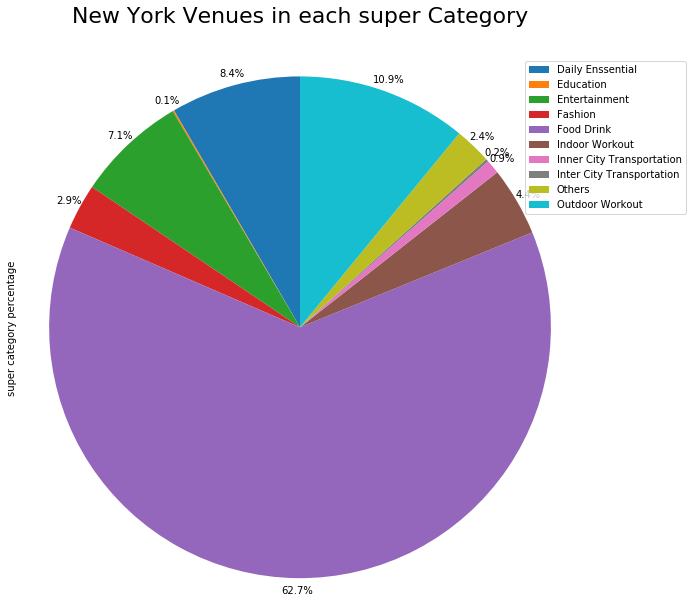

In [59]:
explode_list = [0,0,0,0,0,0,0,0,0,0]
venues_pie.plot.pie(y = 'super category percentage',
                    autopct = '%1.1f%%',
                    pctdistance = 1.05,
                    figsize = (10,10),
                    startangle=90,labels = None, 
                    explode = explode_list)
plt.title('New York Venues in each super Category',y = 1.05,fontsize = 22)
plt.axis('equal')
plt.legend(labels=venues_pie.index,loc = 'upper right',bbox_to_anchor = (1.2,1))
plt.show()